In [1]:
import GPy
import numpy as np
import GPadversarial
import matplotlib.pyplot as plt
%matplotlib inline
import mnist

#munge data from mnist
rawX = mnist.train_images().astype(np.float32)
def subsample(X,step=3):
    return np.array([im[0::step,0::step] for im in X])
rawX = subsample(rawX)

allX = rawX.reshape(60000,np.prod(rawX.shape[1:])) #flatten it
ally = mnist.train_labels()
keep = ally<2
allX = allX[keep,:]
ally = ally[keep]
ally = ally[:,None]
X = allX[0:300,:]
y = ally[0:300,:]
testX = allX[500:600,:]
testy = ally[500:600,:]

# GP Simple Classifier

Here we demonstrate attacking the simple GP classifier

In [2]:
#build model
m = GPadversarial.build_simple_GP_model(X,y)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s16  0003   1.890708e+02   3.788846e-01 
    01s93  0035   2.133011e+01   2.556945e-13 
Runtime:     01s93
Optimization status: Converged



In [3]:
#compute classification accuracy on test data.
pred, _ = m.predict(testX)
np.mean((pred>0.5)==(testy==1))

1.0

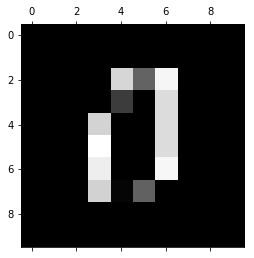

In [4]:
#a digit...
plt.matshow(testX[0:1,:].reshape(rawX.shape[1],rawX.shape[2]),cmap='gray')

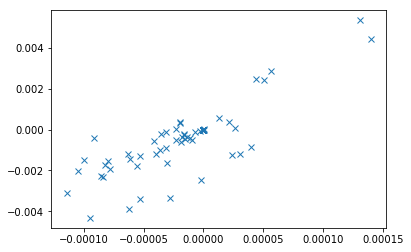

In [5]:
#the gradient of the latent function f and the posterior pi,
#are not necessarily completely proportional, as it depends on how far 
#from 0 the latent function is, and its variance:
fgrads = GPadversarial.get_numerical_f_grad(m,testX[0:1,:].copy())
pigrads = GPadversarial.get_numerical_pi_grad(m,testX[0:1,:].copy())
est = GPadversarial.calc_df_dx(m,testX[0:1,:].copy())
plt.plot(pigrads,est,'x')

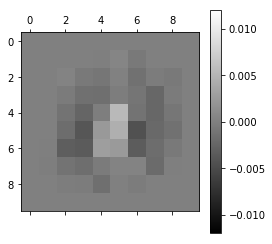

In [6]:
#let's see the saliency map
plt.matshow(est.reshape(rawX.shape[1],rawX.shape[2]),cmap='gray',clim=[-0.012,0.012])
plt.colorbar()

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s18  0003   1.893301e+02   2.667624e-02 
    01s24  0017   8.806987e+01   5.379184e-01 
    02s68  0037   1.864171e+01   2.482143e-05 

 /home/mike/GPy/GPy/kern/src/stationary.py:129: RuntimeWarning:overflow encountered in square
 /home/mike/GPy/GPy/kern/src/stationary.py:130: RuntimeWarning:invalid value encountered in add



Runtime:     02s68
Optimization status: Converged



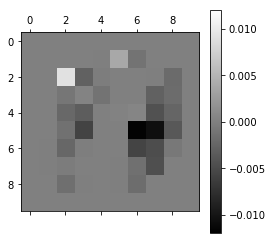

In [7]:
#side note, you'll notice the saliency map is very different if we turn on ARD. 
#This means each pixel can have a different lengthscale;
mARDon = GPadversarial.build_simple_GP_model(X,y,ARD=True)
estARDon = GPadversarial.calc_df_dx(mARDon,testX[0:1,:].copy())
plt.matshow(estARDon.reshape(rawX.shape[1],rawX.shape[2]),cmap='gray',clim=[-0.012,0.012])
plt.colorbar()

Before and after...
0
1
2
3
Crossed boundary after 4 changes


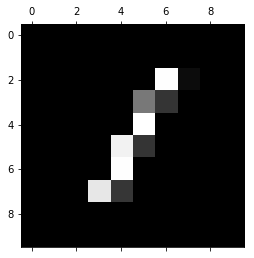

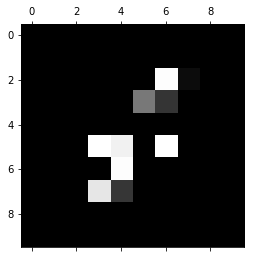

In [14]:
#launching an attack...
#hint, try changing the 'changedir'
print("Before and after...")
advX = testX[1:2,:].copy() #the initial test point we're going to use...
plt.matshow(advX.reshape(rawX.shape[1],rawX.shape[2]),cmap='gray')
advsample, pred, N = GPadversarial.generate_adversarial_example(m, advX, changedir=0)
if advsample is not None:
    print("Crossed boundary after %d changes" % N)
    plt.matshow(advsample.reshape(rawX.shape[1],rawX.shape[2]),cmap='gray')
else:
    print("Failed to find adversarial example")

# GP LVM

Here we demonstrate two attacks of the GP LVM.

In latent space we make predictions using a simple linear classifier